<a href="https://colab.research.google.com/github/SerenaD005/CS634-DataMiningProject-1/blob/master/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT**: **[Google Analytics Customer Revenue Prediction](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview)**

#### **The fundamental steps we will be taking in this project are:**


>1.   **Understand the Objective of this project**
2.   **Data Collection & Data Preperation**
3.   **Modeling & Evaluation**
4.   **Communicate/Present Results**


# **1 - Understanding the Objective**
---

### **Predict how much GStore customers will spend**

In this [Project](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview), we’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to **predict revenue per customer**.
 
**What are we predicting?**

We are predicting the natural log of the sum of all transactions per user.

**Evaluation Metric**

***`RMSE`*** - *Root Mean Squared Error*

**RMSE** is the standard deviation of residuals (predictions errors). When we scatter plot the target_test values and predictions, the RMSE tells us how concentrated are those points around the line of best fit.

![RSME](./rsme.jpg)


# **2 - Data Collection & Data Preperation**
---

## **Mount** the **Google** **Drive** on to the Notebook.


---

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# to load kaggle API
!pip install -q kaggle 
from google.colab import files 
uploaded = files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
#now we install 7zip
!apt-get install p7zip-full

In [0]:
!kaggle datasets download -d niteshmistry/minigacustomerrevenueprediction

In [0]:
!7za e minigacustomerrevenueprediction.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 16767918 bytes (16 MiB)

Extracting archive: minigacustomerrevenueprediction.zip
--
Path = minigacustomerrevenueprediction.zip
Type = zip
Physical Size = 16767918

  0%    
Would you like to replace the existing file:
  Path:     ./mini-test.csv
  Size:     33552335 bytes (32 MiB)
  Modified: 2019-11-02 19:51:56
with the file from archive:
  Path:     mini-test.csv
  Size:     33552335 bytes (32 MiB)
  Modified: 2019-11-02 19:51:56
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

## **Import** the necessary **libraries** that are required to run this notebook:
---
>1. **JSON**
2. **Pandas**
3. **NumPy**
4. **MatPlotLib**
5. **Plotly**  - Plot graphs
6. **SKLearn** - For model selection, preprocessing, metrics



In [0]:
import os
import time
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import datetime
from sklearn.linear_model import LinearRegression




%matplotlib inline


## **Datasets** that are required for this project that are necessary to run the notebook :
---
>1. **TRAIN Dataset** - *`train.csv`* (315 MB)
2. **TEST Dataset** - *`test.csv`* (32 MB)

### Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

## The **data fields** in the given files are

* **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
* **channelGrouping** - The channel via which the user came to the Store.
* **date** - The date on which the user visited the Store.
* **device** - The specifications for the device used to access the Store.
* **geoNetwork** - This section contains information about the geography of the user.
* **sessionId** - A unique identifier for this visit to the store.
* **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* **totals** - This section contains aggregate values across the session.
* **trafficSource** - This section contains information about the Traffic Source from which the session originated.
* **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
* **visitStartTime** - The timestamp (expressed as POSIX time).

***NOTE***: Some of the fields are in json format. We will have to transform them into Dataframe


## **LOAD** the data files that are required:
---

In [0]:
TRAIN_FILE = '/content/mini-train.csv'
TEST_FILE = '/content/mini-test.csv'

#------------------------------------------------------------------------------------------------
# COMMON CSV DATA FILE LOADER - RETURN DATAFRAME
#------------------------------------------------------------------------------------------------

def convertCSVtoDF(csv_path, nrows):

    df = pd.read_csv(csv_path, dtype={"fullVisitorId": "str"}, nrows=nrows)
    print(f"LOADED: {os.path.basename(csv_path)}   SHAPE: {df.shape}")
    
    return df

#------------------------------------------------------------------------------------------------
# LOAD TRAINING DATASET file into DATAFRAME
#------------------------------------------------------------------------------------------------
train_df = convertCSVtoDF(TRAIN_FILE,None)
test_df = convertCSVtoDF(TEST_FILE,None)

#------------------------------------------------------------------------------------------------
# LISTING HEADERS AND SAMPLE RECORDS (5)
#------------------------------------------------------------------------------------------------
print("\n")
print(train_df.columns)


LOADED: mini-train.csv   SHAPE: (20000, 59)
LOADED: mini-test.csv   SHAPE: (2000, 59)


Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bo

In [0]:
#------------------------------------------------------------------------------------------------
# FUNCTION REMOVING EMPTY COLUMNS with value "not available in demo dataset"
#------------------------------------------------------------------------------------------------

def removeUselessColumns(df):
  EMPTY_COLUMNS = []

  dataframe = df

  for column in train_df.columns:
    if train_df[column][0] == 'not available in demo dataset':
      EMPTY_COLUMNS.append(column)
  
  print("DATAFRAME IS " + str(len(dataframe.columns)) + " COLUMNS...")
  print("FOUND " + str(len(EMPTY_COLUMNS)) + " USELESS COLUMNS...")
  print("COLUMNS:  " + str(EMPTY_COLUMNS))
  print("REMOVING " + str(len(EMPTY_COLUMNS)) + " COLUMNS...")
  dataframe.drop(EMPTY_COLUMNS, axis=1, inplace=True)
  print("DATAFRAME IS NOW " + str(len(dataframe.columns)) + " COLUMNS...")

  return dataframe




**REMOVE USELESS COLUMNS** that has values "**NOT AVAILABLE IN DEMO DATASET**

In [0]:
#------------------------------------------------------------------------------------------------
# TRAINING DATAFRAME - REMOVING EMPTY COLUMNS with value "not available in demo dataset"
#------------------------------------------------------------------------------------------------

train_df = removeUselessColumns(train_df)
train_df.head(5)

In [0]:
train_df.describe()

In [0]:
train_df['date'].head()

In [0]:
#------------------------------------------------------------------------------------------------
# TESTING DATAFRAME - REMOVING EMPTY COLUMNS with value "not available in demo dataset"
#------------------------------------------------------------------------------------------------
test_df = removeUselessColumns(test_df)


In [0]:
test_df.head(5)

In [0]:
test_df.describe()

**Impute 0 for ALL missing target values (totals.transactionRevenue)**

## Check Missing Data

In [0]:
# checking missing data
miss_per = {}
for k, v in dict(train_df.isna().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(train_df)
miss_per

In [0]:
#train_df["totals.transactionRevenue"].fillna(0, inplace=True)
#test_df["totals.transactionRevenue"].fillna(0, inplace=True)

**Remove columns that are in TRAINING which are not there in TEST**

In [0]:
print("Columns not in TEST but in TRAIN : ", set(train_df.columns).difference(set(test_df.columns)))

# **3 - MODELING & EVALUTATION**
---

 
 
Since we are predicting the natural log of sum of all transactions of the user, let us sum up the transaction revenue at user level and take a log and then do a scatter plot.


First we have to change the datatype to 'FLOAT' to make sure the value is a dollar value

In [0]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

Next we have to group the USER level transaction to by using the GROUPBY function on the dataframe. This will give us the Total Transaction Value for given user. 

In [0]:
grouped_df_sum = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
grouped_df_sum.sort_values(by=['totals.transactionRevenue'], inplace=True, ascending=False)
grouped_df_sum

In [0]:
ax = grouped_df_sum.hist('totals.transactionRevenue', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Total Transaction Revenue (per User)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Visitors", labelpad=20, weight='bold', size=14)



In [0]:
grouped_df_count = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].count().reset_index()
grouped_df_count.sort_values(by=['totals.transactionRevenue'], inplace=True, ascending=False)
grouped_df_count

In [0]:
ax = grouped_df_count.hist('totals.transactionRevenue', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Total Transaction Count (per User)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Visitors", labelpad=20, weight='bold', size=14)



## **numpy.log1p() in Python**
**numpy.log1p(arr, out = None, *, where = True, casting = ‘same_kind’, order = ‘K’, dtype = None, ufunc ‘log1p’) :**

This mathematical function helps user to calculate **natural logarithmic value of x+1** where x belongs to all the input array elements.

* **log1p is reverse of exp(x) – 1.**


## Plotting log of the revenue by customers

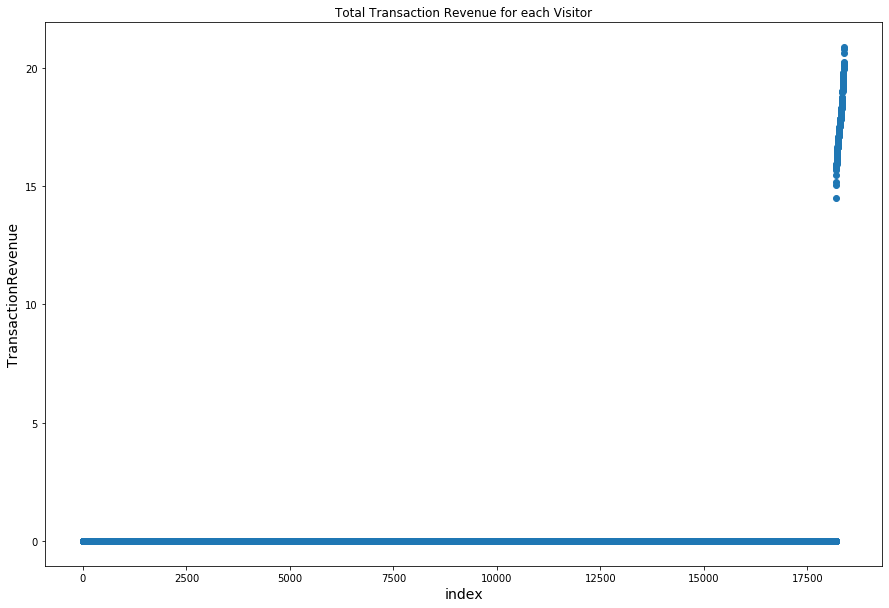

In [0]:
plt.figure(figsize=(15,10))
plt.scatter(range(grouped_df_sum.shape[0]), np.sort(np.log1p(grouped_df_sum["totals.transactionRevenue"].values)))
plt.title('Total Transaction Revenue for each Visitor')
plt.xlabel('index', fontsize=14)
plt.ylabel('TransactionRevenue', fontsize=14)
plt.show()

In [0]:
non_zero_instance = pd.notnull(train_df["totals.transactionRevenue"]).sum()
print("Number of instances in train set with non-zero revenue : ", non_zero_instance, " and ratio is : ", non_zero_instance / train_df.shape[0])
non_zero_revenue = (grouped_df_sum["totals.transactionRevenue"]>0).sum()
print("Number of unique customers with non-zero revenue : ", non_zero_revenue, "and the ratio is : ", non_zero_revenue / train_df.shape[0])

Number of instances in train set with non-zero revenue :  193  and ratio is :  0.00965
Number of unique customers with non-zero revenue :  189 and the ratio is :  0.00945


In [0]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  18384  out of rows :  20000
Number of unique visitors in test set :  1855  out of rows :  2000
Number of common visitors in train and test set :  7


## Removing instances with zero revenue

In [0]:
nzi_train_df = train_df[train_df['totals.transactionRevenue'] > 0]
nzi_train_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
433,Organic Search,"[{'index': '4', 'value': 'North America'}]",20171016,9549826748224805897,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508200705,4,1508200705,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,New York,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,New York NY,(not set),not available in demo dataset,New York,Northern America,NaN,9,NaN,9.0,13.0,261.0,17190000.0,15190000.0,1.0,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
550,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,3700714855829972615,"[{'hitNumber': '1', 'time': '0', 'hour': '15',...",Not Socially Engaged,1508192636,11,1508192636,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Irvine,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Los Angeles CA,(not set),not available in demo dataset,California,Northern America,NaN,15,NaN,12.0,38.0,285.0,13000000.0,8000000.0,1.0,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(none),/,(direct)
555,Organic Search,"[{'index': '4', 'value': 'North America'}]",20171016,1572225825161580042,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1508162218,6,1508162218,Safari,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Mountain View,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,purechat.com,not available in demo dataset,California,Northern America,NaN,15,NaN,15.0,42.0,1044.0,

In [0]:
nzi_test_df = test_df[test_df['totals.transactionRevenue'] > 0]
nzi_test_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
268,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,0567632072087918290,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1526043913,1,1526043913,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,rr.com,not available in demo dataset,not available in demo dataset,Northern America,NaN,11,1.0,10.0,53,302.0,2.499000e+07,2.199000e+07,1.0,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
353,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,0034941760139500427,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,1526090105,1,1526090105,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Mountain View,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,15,1.0,11.0,10,169.0,1.519900e+08,1.499900e+08,1.0,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
369,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,7417113168654151999,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1526052977,1,1526052977,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo datase

In [0]:
nzi_test_df.count()

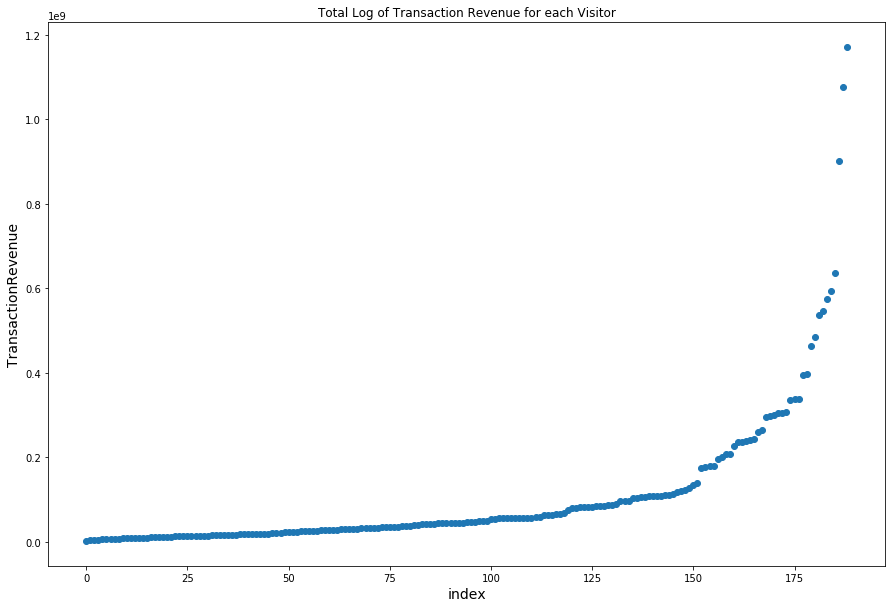

In [0]:
# replotting revenue
plt.figure(figsize=(15,10))
plt.scatter(range(nzi_grouped_df_sum.shape[0]), np.sort(nzi_grouped_df_sum["totals.transactionRevenue"].values))
plt.title('Total Log of Transaction Revenue for each Visitor')
plt.xlabel('index', fontsize=14)
plt.ylabel('TransactionRevenue', fontsize=14)
plt.show()

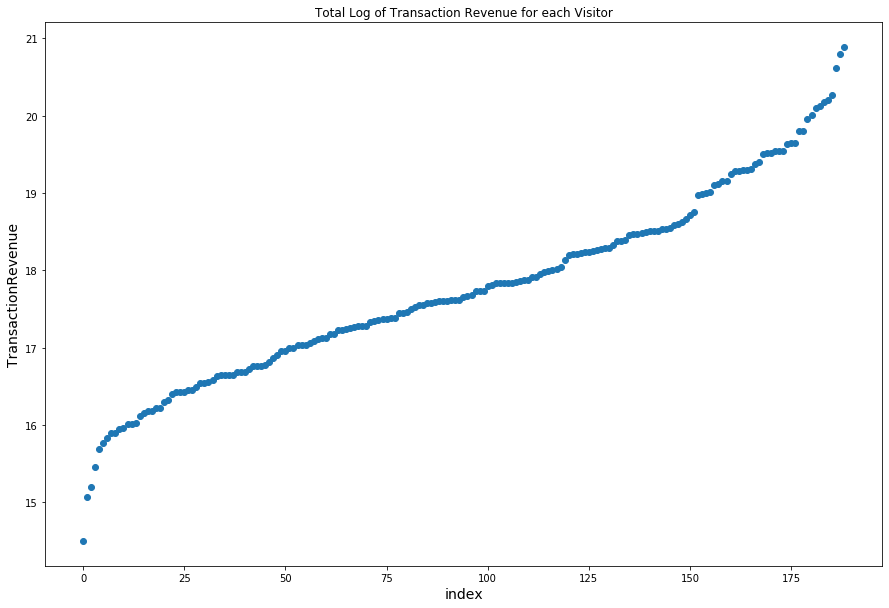

In [0]:
# replotting log(revenue)
nzi_grouped_df_sum = nzi_train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
plt.figure(figsize=(15,10))
plt.scatter(range(nzi_grouped_df_sum.shape[0]), np.sort(np.log1p(nzi_grouped_df_sum["totals.transactionRevenue"].values)))
plt.title('Total Log of Transaction Revenue for each Visitor')
plt.xlabel('index', fontsize=14)
plt.ylabel('TransactionRevenue', fontsize=14)
plt.show()

In [0]:
nzi_grouped_df_test_sum = nzi_test_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

## Running Regression Model

next, we split 80% of the data to the training set while 20% of the data to test set. The test_size variable is where we actually specifiy the proportion of the test set.

In [0]:
X = nzi_grouped_df_sum['fullVisitorId'].values.reshape(-1,1)
y = nzi_grouped_df_sum['totals.transactionRevenue'].values.reshape(-1,1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [0]:
nzi_grouped_df_sum.fillna(-99999, inplace=True)
nzi_grouped_df_test_sum.fillna(-99999, inplace=True)

In [129]:
#train the linear regression algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [130]:
#to retrieve the intercept
print(regressor.intercept_)

#to retrieve the slope
print(regressor.coef_)

[1.02357714e+08]
[[-9.92268476e-13]]


In [0]:
#make predicitions on the test data 
y_pred = regressor.predict(X_test)

In [132]:
nzi_group_df_test_sum = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
nzi_group_df_test_sum.describe()


,Actual,Predicted
count,3.800000e+01,3.800000e+01
mean,1.620739e+08,9.784446e+07
std,2.508753e+08,3.111850e+06
min,8.490000e+06,9.258285e+07
25%,2.597500e+07,9.530565e+07
50%,6.297000e+07,9.815898e+07
75%,1.760925e+08,1.006159e+08
max,1.171470e+09,1.022955e+08


In [133]:
nzi_group_df_test_sum

,Actual,Predicted
0,3.066700e+08,9.707173e+07
1,1.799700e+08,9.858851e+07
2,3.390300e+08,9.390709e+07
3,7.459000e+07,9.770185e+07
4,5.999000e+07,9.615216e+07
5,9.085000e+07,9.864495e+07
6,1.768300e+08,1.013003e+08
7,3.039000e+07,1.022955e+08
8,2.102000e+07,9.504802e+07
9,1.199900e+08,1.018189e+08


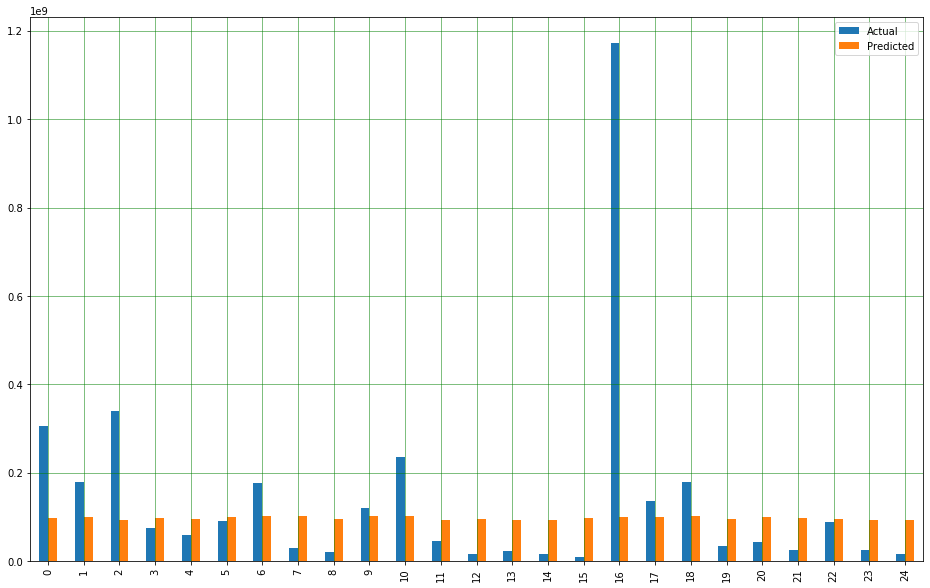

In [134]:
#visualize compairson results with a bar graph
df1 = nzi_group_df_test_sum.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth="0.5", color='black')
plt.show()

In [146]:
len(y_test), len(X_test)

(38, 38)

In [149]:
y_test[0]

array([3.0667e+08])

TypeError: ignored

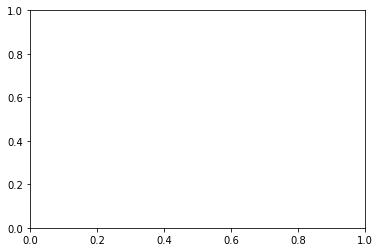

In [147]:
import numpy as np
import matplotlib.pyplot as plt
#test scatter plot with a straight line
plt.scatter(X_test, y_test, color='grey')
#plt.plot(X_test, y_pred, color='red', linewidth=2)
#plt.show()

## Running GBM Model 

We also tried GBM (Gradient Boosting Machine) model. 
We got the kernal from *sudalairajkumar/simple-exploration-baseline-ga-customer-revenue*




In [0]:
train_df['date']

0        20171016
1        20171016
2        20171016
3        20171016
4        20171016
           ...   
19995    20171110
19996    20171110
19997    20171110
19998    20171110
19999    20171110
Name: date, Length: 20000, dtype: int64

In [103]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [0]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)


In [0]:
# Split the train dataset into development and valid 
dev_df = train_df[train_df['date']<=20171231]
val_df = train_df[train_df['date']>20171231]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [0]:
# custom function to run light gbm model
import lightgbm as lgb

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [154]:
# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: nan
Early stopping, best iteration is:
[1]	valid_0's rmse: nan
